In [1]:
import tensorflow as tf

In [2]:
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# https://www.tensorflow.org/datasets/catalog/rock_paper_scissors
ds_train, ds_test = tfds.load("rock_paper_scissors", split=["train", "test"])

In [4]:
train_images = np.array([example['image'].numpy()[:,:,:] for example in ds_train]) # example['image'].numpy()[:,:,0] : RGB 중 R 만 갖고온다. 
train_labels = np.array([example['label'].numpy() for example in ds_train])

test_images = np.array([example['image'].numpy()[:,:,:] for example in ds_test])
test_labels = np.array([example['label'].numpy() for example in ds_test])

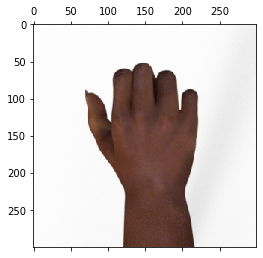

In [5]:
plt.matshow(train_images[2,:,:])

In [6]:
train_labels[2]

0

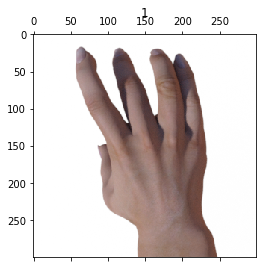

In [7]:
# 바위:0 보 :1 가위:2
plt.matshow(train_images[5,:,:])
plt.title(train_labels[5])
plt.show()

In [8]:
train_images.shape

(2520, 300, 300, 3)

In [9]:
train_labels.shape

(2520,)

In [10]:
# train_images = train_images.reshape(2520, 300, 300, 1)
# test_images = test_images.reshape(372, 300, 300, 1)

In [11]:
# 정규화 
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')
train_images /= 255
test_images /= 255

In [12]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation="relu", input_shape=(300,300,3)))
model.add(tf.keras.layers.MaxPool2D(pool_size=2))
model.add(tf.keras.layers.Conv2D(128, kernel_size=(3,3), activation="relu"))
model.add(tf.keras.layers.MaxPool2D(pool_size=2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation="relu"))
model.add(tf.keras.layers.Dense(32, activation="relu"))
model.add(tf.keras.layers.Dense(3, activation="softmax"))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 149, 149, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 73, 73, 128)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 682112)            0         
                                                                 
 dense (Dense)               (None, 64)                4

In [14]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics = ["accuracy"]) # sparse_categorical_crossentropy one-hot encoding 까지 해준다. 
model_history = model.fit(train_images, train_labels, batch_size=128, epochs=10, validation_split=0.1)

Epoch 1/10
18/18 [==============================] - 30s 920ms/step - loss: 1.9188 - accuracy: 0.3964 - val_loss: 0.8990 - val_accuracy: 0.7619
Epoch 2/10
18/18 [==============================] - 12s 652ms/step - loss: 0.5620 - accuracy: 0.8082 - val_loss: 0.1976 - val_accuracy: 0.9722
Epoch 3/10
18/18 [==============================] - 12s 651ms/step - loss: 0.1084 - accuracy: 0.9749 - val_loss: 0.3299 - val_accuracy: 0.8413
Epoch 4/10
18/18 [==============================] - 12s 659ms/step - loss: 0.2029 - accuracy: 0.9383 - val_loss: 0.0435 - val_accuracy: 0.9921
Epoch 5/10
18/18 [==============================] - 12s 657ms/step - loss: 0.0194 - accuracy: 0.9951 - val_loss: 0.0275 - val_accuracy: 0.9881
Epoch 6/10
18/18 [==============================] - 12s 660ms/step - loss: 0.0050 - accuracy: 0.9996 - val_loss: 0.0201 - val_accuracy: 0.9960
Epoch 7/10
18/18 [==============================] - 12s 658ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0129 - val_accuracy: 0.9960

In [84]:
import cv2
paper_test = cv2.imread("./paper.png")
paper_test = cv2.cvtColor(paper_test, cv2.COLOR_BGR2RGB)
s_test = cv2.imread("./s.png")
s_test = cv2.cvtColor(s_test, cv2.COLOR_BGR2RGB)

In [85]:
s_test = cv2.resize(s_test, (300,300))
s_test = s_test.astype('float32')
s_test /= 255

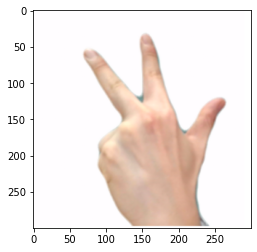

In [86]:
plt.imshow(s_test)

In [87]:
s_test.shape

(300, 300, 3)

In [88]:
s_test = s_test.reshape(1,300,300,3)
np.argmax(model.predict(s_test))

1/1 [==============================] - 0s 17ms/step


0

In [15]:
!pip install -q -U keras-tuner

In [27]:
# https://keras.io/keras_tuner/
import keras_tuner

In [22]:
def build_model(hp):
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation="relu", input_shape=(300,300,1)))
  model.add(tf.keras.layers.MaxPool2D(pool_size=2))
  model.add(tf.keras.layers.Conv2D(128, kernel_size=(3,3), activation="relu"))
  model.add(tf.keras.layers.MaxPool2D(pool_size=2))
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(hp.Choice("Dense layer", [ 64, 128, 256, 512, 1024,2048]), activation='relu'))
  model.add(tf.keras.layers.Dense(64, activation="relu"))
  model.add(tf.keras.layers.Dense(3, activation="softmax"))
  model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics = ["accuracy"])  
  return model

In [25]:
tuner = keras_tuner.RandomSearch(
    build_model, 
    objective='val_accuracy',
    max_trials=8
)


In [26]:
tuner.search(train_images, train_labels, epochs=10, batch_size=32)
